## 1) Data Exploration

a.

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Python Spark regression example").config("config.option", "value").getOrCreate()


df = spark.read.csv('mpst_full_data.csv', escape='"',sep=",",encoding='UTF-8',comment=None, header=True,multiLine=True,inferSchema=True)
# colNumber
print("countNumber: ",df.count())

# show50col
df.show(50)

result = df.select('tags').rdd.flatMap(lambda x: x).flatMap(lambda x: x.split(", ")).countByValue()


sortTags = sorted(result.items(), key=lambda item:item[1],reverse=True)
list = []
for num in range(0,10):
    list.append(sortTags[num])


countNumber:  14828
+---------+--------------------+--------------------+--------------------+-----+---------------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|
+---------+--------------------+--------------------+--------------------+-----+---------------+
|tt0057603|I tre volti della...|Note: this synops...|cult, horror, got...|train|           imdb|
|tt1733125|Dungeons & Dragon...|Two thousand year...|            violence|train|           imdb|
|tt0033045|The Shop Around t...|Matuschek's, a gi...|            romantic| test|           imdb|
|tt0113862|  Mr. Holland's Opus|Glenn Holland, no...|inspiring, romant...|train|           imdb|
|tt0086250|            Scarface|In May 1980, a Cu...|cruelty, murder, ...|  val|           imdb|
|tt1315981|        A Single Man|George Falconer (...|romantic, queer, ...|  val|           imdb|
|tt0249380|           Baise-moi|Baise-moi tells t...|gothic, cruelty, ...|train|      wikipedia|
|tt0408790

b.

In [7]:
df.describe().show()

+-------+---------+-----------------+-------------------------+--------------------+-----+---------------+
|summary|  imdb_id|            title|            plot_synopsis|                tags|split|synopsis_source|
+-------+---------+-----------------+-------------------------+--------------------+-----+---------------+
|  count|    14828|            14828|                    14828|               14828|14828|          14828|
|   mean|     null|615.7078947368421|                     null|                null| null|           null|
| stddev|     null|820.9172438097585|                     null|                null| null|           null|
|    min|tt0000091|                $|     ".hack//Roots" fo...|              absurd| test|           imdb|
|    max|tt6583664|        Üç Maymun|《龍虎門》Dragon Tiger...|whimsical, violen...|  val|      wikipedia|
+-------+---------+-----------------+-------------------------+--------------------+-----+---------------+



c and d.

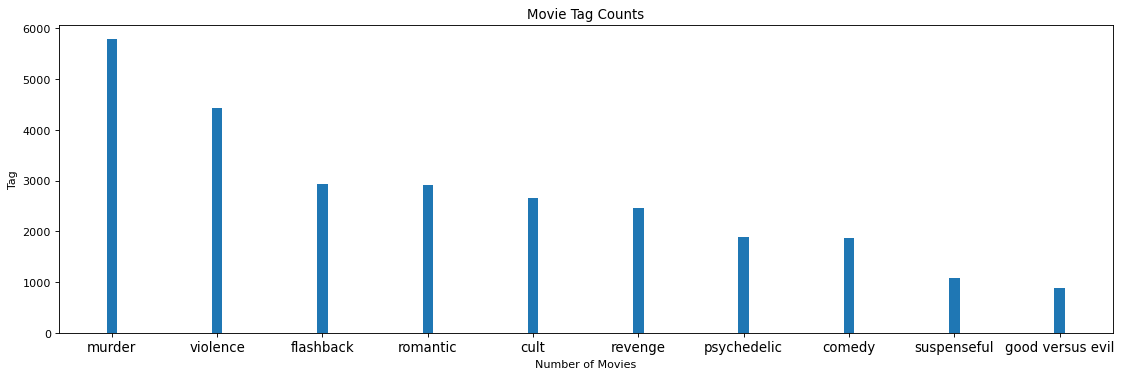

In [4]:
import numpy as np
import matplotlib.pyplot as plt
x1=np.arange(10)
y1=np.array([list[0][1],list[1][1],list[2][1],list[3][1],list[4][1],list[5][1],list[6][1],list[7][1],list[8][1],list[9][1]])
bar_width=0.1
plt.figure(figsize=(17, 5), dpi=80)
plt.bar(x1,y1,tick_label=[list[0][0],list[1][0],list[2][0],list[3][0],list[4][0],list[5][0],list[6][0],list[7][0],list[8][0],list[9][0]],width=bar_width)
plt.xticks(fontsize=12)
plt.title("Movie Tag Counts")
plt.xlabel("Number of Movies")
plt.ylabel("Tag")
plt.show()

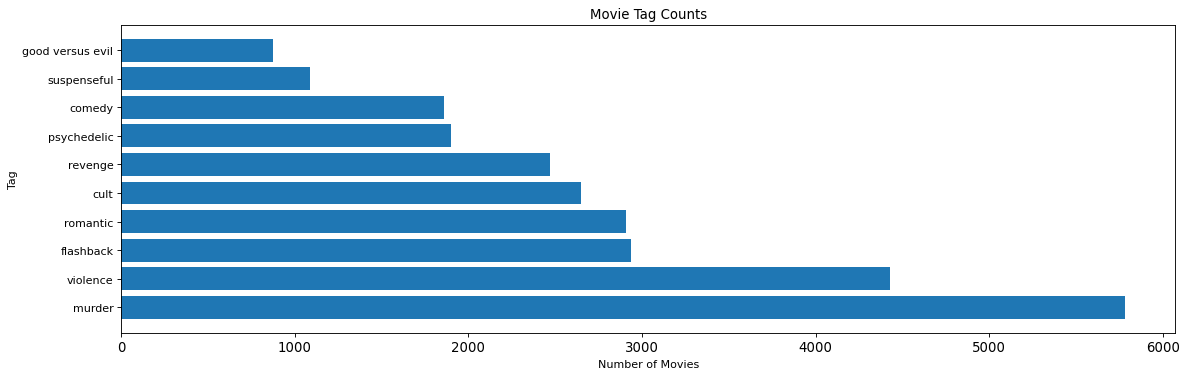

In [10]:
plt.figure(figsize=(17, 5), dpi=80)
plt.barh(x1,y1,tick_label=[list[0][0],list[1][0],list[2][0],list[3][0],list[4][0],list[5][0],list[6][0],list[7][0],list[8][0],list[9][0]])
plt.xticks(fontsize=12)
plt.title("Movie Tag Counts")
plt.xlabel("Number of Movies")
plt.ylabel("Tag")
plt.show()

## 2). Build Models

a).

In [26]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import when

top_tags = [list[0][0],list[1][0],list[2][0],list[3][0],list[4][0],list[5][0],list[6][0],list[7][0],list[8][0],list[9][0]]

In [27]:
from pyspark.sql.functions import split, explode
# Filter the DataFrame to only include movies with one of the top 10 tags
df_c= df.withColumn('tag',explode(split('tags',',')))
df_filtered = df_c.filter(df_c.tag.isNotNull()).filter(df_c.tag.isin(top_tags))
# Create a column for the target variable by converting the tag column to a binary variable
df_filtered = df_filtered.withColumn("target", when(df_filtered.tag.isin(top_tags), 1).otherwise(0))
# Split the data into training and testing sets
(trainingData, testData) = df_filtered.randomSplit([0.8, 0.2], seed=1234)

In [36]:
df_filtered.show(5)

+---------+--------------------+--------------------+--------------------+-----+---------------+--------+------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|     tag|target|
+---------+--------------------+--------------------+--------------------+-----+---------------+--------+------+
|tt0057603|I tre volti della...|Note: this synops...|cult, horror, got...|train|           imdb|    cult|     1|
|tt1733125|Dungeons & Dragon...|Two thousand year...|            violence|train|           imdb|violence|     1|
|tt0033045|The Shop Around t...|Matuschek's, a gi...|            romantic| test|           imdb|romantic|     1|
|tt1315981|        A Single Man|George Falconer (...|romantic, queer, ...|  val|           imdb|romantic|     1|
|tt0021079|       Little Caesar|Small-time Italia...|            violence|train|           imdb|violence|     1|
+---------+--------------------+--------------------+--------------------+-----+---------------+

b) and c)

In [29]:
# Define the tokenizer and stopwords remover
tokenizer = RegexTokenizer(inputCol="plot_synopsis", outputCol="tokens", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_tokens")

# Define the vectorizers
hashingTF = HashingTF(inputCol=stopwords_remover.getOutputCol(), outputCol="raw_features")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

# Define the logistic regression model
lr = LogisticRegression(labelCol="target", maxIter=10)

In [34]:
# Define the pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf, lr])

# Train the model
model = pipeline.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

In [35]:
predictions.show(5)

+---------+--------------------+--------------------+--------------------+-----+---------------+-----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|        tag|target|              tokens|     filtered_tokens|        raw_features|            features|       rawPrediction|probability|prediction|
+---------+--------------------+--------------------+--------------------+-----+---------------+-----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+
|tt0000966|A Midsummer Night...|The play consists...|   romantic, fantasy|train|      wikipedia|   romantic|     1|[the, play, consi...|[play, consists, ...|(262144,[1923,399...|(262144,[1923,399...|[-Infinity,Infinity]|  [0.0,1.0]|       1.0|
|tt0002130|           L'

d)

In [55]:
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf])
# Train the model
model = pipeline.fit(df_filtered)

# Make predictions on the test data
predictions = model.transform(df_filtered)

In [56]:
predictions.show(5)

+---------+--------------------+--------------------+--------------------+-----+---------------+--------+------+--------------------+--------------------+--------------------+--------------------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|     tag|target|              tokens|     filtered_tokens|        raw_features|            features|
+---------+--------------------+--------------------+--------------------+-----+---------------+--------+------+--------------------+--------------------+--------------------+--------------------+
|tt0057603|I tre volti della...|Note: this synops...|cult, horror, got...|train|           imdb|    cult|     1|[note, this, syno...|[note, synopsis, ...|(262144,[329,917,...|(262144,[329,917,...|
|tt1733125|Dungeons & Dragon...|Two thousand year...|            violence|train|           imdb|violence|     1|[two, thousand, y...|[two, thousand, y...|(262144,[10077,12...|(262144,[10077,12...|
|tt0033045|The 

In [57]:
from pyspark.sql.functions import col

In [46]:
import pyspark.sql.functions as F 
categ = predictions.select('tag').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [F.when(F.col('tag') == cat,1).otherwise(0)\
            .alias(str(cat)) for cat in categ]
pred1 = predictions.select(exprs+predictions.columns)

In [47]:
pred1.show(5)

+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+---------+--------------------+--------------------+--------------------+-----+---------------+--------+------+--------------------+--------------------+--------------------+--------------------+
|romantic|flashback|good versus evil|murder|violence|revenge|cult|suspenseful|psychedelic|comedy|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|     tag|target|              tokens|     filtered_tokens|        raw_features|            features|
+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+---------+--------------------+--------------------+--------------------+-----+---------------+--------+------+--------------------+--------------------+--------------------+--------------------+
|       0|        0|               0|     0|       0|      0|   1|          0|          0|     0|tt0057603|I tre volti de

In [48]:
pred1 = pred1.select('plot_synopsis', 'features', 'romantic', 'flashback', 'good versus evil', 'murder', 'violence', 'revenge', 'cult', 'suspenseful', 'psychedelic', 'comedy', 'split')

In [49]:
pred1.show(5)

+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|       plot_synopsis|            features|romantic|flashback|good versus evil|murder|violence|revenge|cult|suspenseful|psychedelic|comedy|split|
+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|Note: this synops...|(262144,[329,917,...|       0|        0|               0|     0|       0|      0|   1|          0|          0|     0|train|
|Two thousand year...|(262144,[10077,12...|       0|        0|               0|     0|       1|      0|   0|          0|          0|     0|train|
|Matuschek's, a gi...|(262144,[102,329,...|       1|        0|               0|     0|       0|      0|   0|          0|          0|     0| test|
|George Falconer (...|(262144,[619,1818...|       1|        0|               0|     0|       0|      0|   0|          0|    

e)

In [51]:
trainingData = pred1.filter(pred1.split == 'train')
testingData = pred1.filter(pred1.split == 'test')
valData = pred1.filter(pred1.split == 'val')

In [63]:
trainingData.show(5)

+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|       plot_synopsis|            features|romantic|flashback|good versus evil|murder|violence|revenge|cult|suspenseful|psychedelic|comedy|split|
+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|Note: this synops...|(262144,[329,917,...|       0|        0|               0|     0|       0|      0|   1|          0|          0|     0|train|
|Two thousand year...|(262144,[10077,12...|       0|        0|               0|     0|       1|      0|   0|          0|          0|     0|train|
|Small-time Italia...|(262144,[1546,459...|       0|        0|               0|     0|       1|      0|   0|          0|          0|     0|train|
|The movie begins ...|(262144,[476,535,...|       0|        0|               0|     0|       0|      1|   0|          0|    

In [64]:
testingData.show(5)

+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|       plot_synopsis|            features|romantic|flashback|good versus evil|murder|violence|revenge|cult|suspenseful|psychedelic|comedy|split|
+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|Matuschek's, a gi...|(262144,[102,329,...|       1|        0|               0|     0|       0|      0|   0|          0|          0|     0| test|
|Hours after the e...|(262144,[134,365,...|       0|        0|               1|     0|       0|      0|   0|          0|          0|     0| test|
|The movie opens w...|(262144,[1277,154...|       0|        0|               0|     0|       0|      1|   0|          0|          0|     0| test|
|Six friends, Chri...|(262144,[956,3280...|       0|        0|               0|     0|       0|      0|   1|          0|    

In [65]:
valData.show(5)

+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|       plot_synopsis|            features|romantic|flashback|good versus evil|murder|violence|revenge|cult|suspenseful|psychedelic|comedy|split|
+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+
|George Falconer (...|(262144,[619,1818...|       1|        0|               0|     0|       0|      0|   0|          0|          0|     0|  val|
|The film begins w...|(262144,[212,432,...|       0|        1|               0|     0|       0|      0|   0|          0|          0|     0|  val|
|On New Years Eve,...|(262144,[329,781,...|       0|        0|               0|     0|       0|      0|   0|          1|          0|     0|  val|
|In the mid-21st c...|(262144,[2325,392...|       0|        0|               0|     0|       0|      0|   1|          0|    

f)

In [67]:
# Define
from pyspark.ml.classification import OneVsRest, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col

**romantic**

In [87]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_romantic = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='romantic')

# Fit the model to the data.
lgModel_romantic = lg_romantic.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_romantic = lgModel_romantic.transform(testingData)

In [88]:
lg_pred_romantic.show(5)

+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+--------------------+--------------------+----------+
|       plot_synopsis|            features|romantic|flashback|good versus evil|murder|violence|revenge|cult|suspenseful|psychedelic|comedy|split|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------+---------+----------------+------+--------+-------+----+-----------+-----------+------+-----+--------------------+--------------------+----------+
|Matuschek's, a gi...|(262144,[102,329,...|       1|        0|               0|     0|       0|      0|   0|          0|          0|     0| test|[-0.9334870266008...|[0.28221780821405...|       1.0|
|Hours after the e...|(262144,[134,365,...|       0|        0|               1|     0|       0|      0|   0|          0|          0|     0| test|[13.3895760501503...|[0.99999846898184...|       0.0|
|The 

In [89]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="romantic", predictionCol="prediction", metricName="accuracy")
accuracy_romantic = eval_accuracy.evaluate(lg_pred_romantic)
accuracy_romantic

0.7982767359351242

In [90]:
eval_f1 = MulticlassClassificationEvaluator(labelCol="romantic", predictionCol="prediction", metricName="f1")
f1score_romantic = eval_f1.evaluate(lg_pred_romantic)
f1score_romantic

0.8143428005463075

**flashback**

In [75]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_flashback = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='flashback')

# Fit the model to the data.
lgModel_flashback = lg_flashback.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_flashback = lgModel_flashback.transform(testingData)

In [76]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="flashback", predictionCol="prediction", metricName="accuracy")
accuracy_flashback = eval_accuracy.evaluate(lg_pred_flashback)

eval_f1 = MulticlassClassificationEvaluator(labelCol="flashback", predictionCol="prediction", metricName="f1")
f1score_flashback = eval_f1.evaluate(lg_pred_flashback)

**good versus evil**

In [77]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_good_versus_evil = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='good versus evil')

# Fit the model to the data.
lgModel_good_versus_evil = lg_good_versus_evil.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_good_versus_evil = lgModel_good_versus_evil.transform(testingData)

In [78]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="good versus evil", predictionCol="prediction", metricName="accuracy")
accuracy_good_versus_evil = eval_accuracy.evaluate(lg_pred_good_versus_evil)

eval_f1 = MulticlassClassificationEvaluator(labelCol="good versus evil", predictionCol="prediction", metricName="f1")
f1score_good_versus_evil = eval_f1.evaluate(lg_pred_good_versus_evil)

**murder**

In [79]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_murder = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='murder')

# Fit the model to the data.
lgModel_murder = lg_murder.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_murder = lgModel_murder.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="murder", predictionCol="prediction", metricName="accuracy")
accuracy_murder = eval_accuracy.evaluate(lg_pred_murder)

eval_f1 = MulticlassClassificationEvaluator(labelCol="murder", predictionCol="prediction", metricName="f1")
f1score_murder = eval_f1.evaluate(lg_pred_murder)

**violence**

In [80]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_violence = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='violence')

# Fit the model to the data.
lgModel_violence = lg_violence.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_violence = lgModel_violence.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="violence", predictionCol="prediction", metricName="accuracy")
accuracy_violence = eval_accuracy.evaluate(lg_pred_violence)

eval_f1 = MulticlassClassificationEvaluator(labelCol="violence", predictionCol="prediction", metricName="f1")
f1score_violence = eval_f1.evaluate(lg_pred_violence)

**revenge**

In [81]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_revenge = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='revenge')

# Fit the model to the data.
lgModel_revenge = lg_revenge.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_revenge = lgModel_revenge.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="revenge", predictionCol="prediction", metricName="accuracy")
accuracy_revenge = eval_accuracy.evaluate(lg_pred_revenge)

eval_f1 = MulticlassClassificationEvaluator(labelCol="revenge", predictionCol="prediction", metricName="f1")
f1score_revenge = eval_f1.evaluate(lg_pred_revenge)

**cult**

In [82]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_cult = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='cult')

# Fit the model to the data.
lgModel_cult = lg_cult.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_cult = lgModel_cult.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="cult", predictionCol="prediction", metricName="accuracy")
accuracy_cult = eval_accuracy.evaluate(lg_pred_cult)

eval_f1 = MulticlassClassificationEvaluator(labelCol="cult", predictionCol="prediction", metricName="f1")
f1score_cult = eval_f1.evaluate(lg_pred_cult)

**suspenseful**

In [83]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_suspenseful = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='suspenseful')

# Fit the model to the data.
lgModel_suspenseful = lg_suspenseful.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_suspenseful = lgModel_suspenseful.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="suspenseful", predictionCol="prediction", metricName="accuracy")
accuracy_suspenseful = eval_accuracy.evaluate(lg_pred_suspenseful)

eval_f1 = MulticlassClassificationEvaluator(labelCol="suspenseful", predictionCol="prediction", metricName="f1")
f1score_suspenseful = eval_f1.evaluate(lg_pred_suspenseful)

**psychedelic**

In [84]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_psychedelic = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='psychedelic')

# Fit the model to the data.
lgModel_psychedelic = lg_psychedelic.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_psychedelic = lgModel_psychedelic.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="psychedelic", predictionCol="prediction", metricName="accuracy")
accuracy_psychedelic = eval_accuracy.evaluate(lg_pred_psychedelic)

eval_f1 = MulticlassClassificationEvaluator(labelCol="psychedelic", predictionCol="prediction", metricName="f1")
f1score_psychedelic = eval_f1.evaluate(lg_pred_psychedelic)

**comedy**

In [85]:
# Define the logistic regression model
# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_comedy = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='comedy')

# Fit the model to the data.
lgModel_comedy = lg_comedy.fit(trainingData)

# Given a dataset, predict each point's label, and show the results.
lg_pred_comedy = lgModel_comedy.transform(testingData)

eval_accuracy = MulticlassClassificationEvaluator(labelCol="comedy", predictionCol="prediction", metricName="accuracy")
accuracy_comedy = eval_accuracy.evaluate(lg_pred_comedy)

eval_f1 = MulticlassClassificationEvaluator(labelCol="comedy", predictionCol="prediction", metricName="f1")
f1score_comedy = eval_f1.evaluate(lg_pred_comedy)

In [93]:
from pyspark.sql.types import StructType,StructField, StringType, FloatType
model_performance = [("romantic", accuracy_romantic, f1score_romantic),
    ("flashback", accuracy_flashback, f1score_flashback),
    ("good versus evil", accuracy_good_versus_evil, f1score_good_versus_evil),
    ("murder", accuracy_murder, f1score_murder),
    ("violence", accuracy_violence, f1score_violence),
    ("revenge", accuracy_revenge, f1score_revenge),
    ("cult", accuracy_cult, f1score_cult),
    ("suspenseful", accuracy_suspenseful, f1score_suspenseful),
    ("psychedelic", accuracy_psychedelic, f1score_psychedelic),
    ("comedy",accuracy_comedy, f1score_comedy)
  ]

schema = StructType([ \
    StructField("Model",StringType(),True), \
    StructField("Accuracy Score",FloatType(),True), \
    StructField("F1 Score ",FloatType(),True)
  ])
 
df_model_performance = spark.createDataFrame(data=model_performance,schema=schema)
df_model_performance.printSchema()
df_model_performance.show()

root
 |-- Model: string (nullable = true)
 |-- Accuracy Score: float (nullable = true)
 |-- F1 Score : float (nullable = true)

+----------------+--------------+---------+
|           Model|Accuracy Score|F1 Score |
+----------------+--------------+---------+
|        romantic|     0.7982767|0.8143428|
|       flashback|    0.93005574|0.9283128|
|good versus evil|    0.91028893|0.9179823|
|          murder|    0.75722253| 0.766153|
|        violence|    0.74961984|0.7549499|
|         revenge|    0.80334514|0.8029887|
|            cult|      0.797263|0.8135181|
|     suspenseful|     0.9239736|0.9262491|
|     psychedelic|    0.88596046|0.8890193|
|          comedy|     0.7987836|0.8061023|
+----------------+--------------+---------+



## 3). Inference

The data comes from the link: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

In [99]:
moive_wiki = spark.read.csv('wiki_movie_plots_deduped.csv', escape='"',sep=",",encoding='UTF-8',comment=None, header=True,multiLine=True,inferSchema=True)
# colNumber
print("countNumber: ",moive_wiki.count())

# show50col
moive_wiki_plot = moive_wiki.select('Plot')

countNumber:  34886


In [105]:
moive_wiki_plot_sample = moive_wiki_plot.limit(10)
moive_wiki_plot_sample = moive_wiki_plot_sample.withColumnRenamed('Plot', 'plot_synopsis')

In [106]:
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashingTF, idf])
# Train the model
model_wiki = pipeline.fit(moive_wiki_plot_sample)

# Make predictions on the test data
predictions_wiki = model.transform(moive_wiki_plot_sample)

In [107]:
predictions_wiki.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|       plot_synopsis|              tokens|     filtered_tokens|        raw_features|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|A bartender is wo...|[a, bartender, is...|[bartender, worki...|(262144,[181,5592...|(262144,[181,5592...|
|The moon, painted...|[the, moon, paint...|[moon, painted, s...|(262144,[303,4213...|(262144,[303,4213...|
|The film, just ov...|[the, film, just,...|[film, minute, lo...|(262144,[1066,542...|(262144,[1066,542...|
|Lasting just 61 s...|[lasting, just, 6...|[lasting, 61, sec...|(262144,[1232,219...|(262144,[1232,219...|
|The earliest know...|[the, earliest, k...|[earliest, known,...|(262144,[7286,748...|(262144,[7286,748...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [108]:
training_wiki = predictions_wiki.select('features')

In [114]:
# Define
from pyspark.ml.classification import OneVsRest, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col

wiki_pred_romantic = lgModel_romantic.transform(training_wiki)
wiki_pred_flashback = lgModel_flashback.transform(training_wiki)
wiki_pred_good_versus_evil = lgModel_good_versus_evil.transform(training_wiki)
wiki_pred_murder = lgModel_murder.transform(training_wiki)
wiki_pred_violence = lgModel_violence.transform(training_wiki)
wiki_pred_revenge = lgModel_revenge.transform(training_wiki)
wiki_pred_cult = lgModel_cult.transform(training_wiki)
wiki_pred_suspenseful = lgModel_suspenseful.transform(training_wiki)
wiki_pred_psychedelic = lgModel_psychedelic.transform(training_wiki)
wiki_pred_comedy = lgModel_comedy.transform(training_wiki)

In [115]:
wiki_pred_romantic.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[2.07135010381483...|[0.88808721630644...|       0.0|
|(262144,[303,4213...|[2.41387110652224...|[0.91787894740529...|       0.0|
|(262144,[1066,542...|[2.27591722165508...|[0.90686277683432...|       0.0|
|(262144,[1232,219...|[1.71034360502258...|[0.84688084607307...|       0.0|
|(262144,[7286,748...|[1.89366175980711...|[0.86917247859793...|       0.0|
|(262144,[3329,728...|[2.23173144313786...|[0.90306303568782...|       0.0|
|(262144,[7123,142...|[3.18847688853240...|[0.96039833198283...|       0.0|
|(262144,[16004,17...|[2.32400122548836...|[0.91084539899789...|       0.0|
|(262144,[535,2437...|[1.70504454752687...|[0.84619243400640...|       0.0|
|(262144,[1272,270...|[2.15597093818353...|[0.89622542174317...|       0.0|
+-----------

In [117]:
wiki_pred_flashback.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[3.95693490303349...|[0.98123714227814...|       0.0|
|(262144,[303,4213...|[3.78990653122303...|[0.97790165807609...|       0.0|
|(262144,[1066,542...|[3.64375105909204...|[0.97451254592611...|       0.0|
|(262144,[1232,219...|[3.62634839760577...|[0.97407671332826...|       0.0|
|(262144,[7286,748...|[3.78124528710908...|[0.97771371176895...|       0.0|
|(262144,[3329,728...|[4.28628808663425...|[0.98643076558894...|       0.0|
|(262144,[7123,142...|[3.68725168947373...|[0.97557099285090...|       0.0|
|(262144,[16004,17...|[3.62832726073838...|[0.97412663528555...|       0.0|
|(262144,[535,2437...|[4.86997426936395...|[0.99238487242812...|       0.0|
|(262144,[1272,270...|[3.02942236665353...|[0.95388577085693...|       0.0|
+-----------

In [118]:
wiki_pred_good_versus_evil.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[3.48790023807144...|[0.97034152673400...|       0.0|
|(262144,[303,4213...|[4.03519932273671...|[0.98262507088866...|       0.0|
|(262144,[1066,542...|[4.05792921508301...|[0.98300891200259...|       0.0|
|(262144,[1232,219...|[4.14865233030748...|[0.98445963906970...|       0.0|
|(262144,[7286,748...|[3.97483569154402...|[0.98156388687170...|       0.0|
|(262144,[3329,728...|[3.35616867963486...|[0.96630625738744...|       0.0|
|(262144,[7123,142...|[4.31545577570531...|[0.98681568970776...|       0.0|
|(262144,[16004,17...|[4.12722142786632...|[0.98412834377110...|       0.0|
|(262144,[535,2437...|[4.82831561091284...|[0.99206350681538...|       0.0|
|(262144,[1272,270...|[4.01234080136624...|[0.98223047032800...|       0.0|
+-----------

In [119]:
wiki_pred_murder.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[3.20820572714314...|[0.96114190820444...|       0.0|
|(262144,[303,4213...|[1.70295178379977...|[0.84591986175713...|       0.0|
|(262144,[1066,542...|[3.21205358521103...|[0.96128536382229...|       0.0|
|(262144,[1232,219...|[3.41316790525303...|[0.96811353999202...|       0.0|
|(262144,[7286,748...|[3.39304997508385...|[0.96748662241125...|       0.0|
|(262144,[3329,728...|[3.00228900052112...|[0.95267742915972...|       0.0|
|(262144,[7123,142...|[3.09931143613804...|[0.95686433353759...|       0.0|
|(262144,[16004,17...|[3.23141788297708...|[0.96199961952470...|       0.0|
|(262144,[535,2437...|[3.61734083901943...|[0.97384828713753...|       0.0|
|(262144,[1272,270...|[3.17790280987863...|[0.95999420041109...|       0.0|
+-----------

In [120]:
wiki_pred_violence.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[3.51472969498456...|[0.97110398045793...|       0.0|
|(262144,[303,4213...|[3.28037472985846...|[0.96374937765590...|       0.0|
|(262144,[1066,542...|[2.70346002051378...|[0.93723050337513...|       0.0|
|(262144,[1232,219...|[1.95229611291855...|[0.87569679379208...|       0.0|
|(262144,[7286,748...|[3.33808748450592...|[0.96571257184943...|       0.0|
|(262144,[3329,728...|[2.66570120365400...|[0.93497215611493...|       0.0|
|(262144,[7123,142...|[3.361363771806,-...|[0.96647499252146...|       0.0|
|(262144,[16004,17...|[2.95052546974276...|[0.95028831773288...|       0.0|
|(262144,[535,2437...|[2.88613778727555...|[0.94715690862494...|       0.0|
|(262144,[1272,270...|[2.97627878857275...|[0.95149090345884...|       0.0|
+-----------

In [121]:
wiki_pred_revenge.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[2.84943962172208...|[0.94528970888917...|       0.0|
|(262144,[303,4213...|[3.15622808853997...|[0.95915342564862...|       0.0|
|(262144,[1066,542...|[3.22270232121130...|[0.96167972432411...|       0.0|
|(262144,[1232,219...|[3.86683521308330...|[0.97950437415438...|       0.0|
|(262144,[7286,748...|[3.00939097181442...|[0.95299658097893...|       0.0|
|(262144,[3329,728...|[3.53886588195029...|[0.97177362020616...|       0.0|
|(262144,[7123,142...|[1.96316546138345...|[0.87687511984340...|       0.0|
|(262144,[16004,17...|[3.31278988746492...|[0.96486498226762...|       0.0|
|(262144,[535,2437...|[0.39010736385245...|[0.59630854469133...|       0.0|
|(262144,[1272,270...|[2.81207497271404...|[0.94332485570867...|       0.0|
+-----------

In [122]:
wiki_pred_cult.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[2.70151208529733...|[0.93711580969783...|       0.0|
|(262144,[303,4213...|[3.44104195301703...|[0.96896286667425...|       0.0|
|(262144,[1066,542...|[3.42560708029973...|[0.96849530583942...|       0.0|
|(262144,[1232,219...|[2.34762693781628...|[0.91274541901547...|       0.0|
|(262144,[7286,748...|[3.84672633643086...|[0.97909676069824...|       0.0|
|(262144,[3329,728...|[3.19201133073144...|[0.96053254022136...|       0.0|
|(262144,[7123,142...|[2.37299393913563...|[0.91474463866372...|       0.0|
|(262144,[16004,17...|[3.21906495327168...|[0.96154545532157...|       0.0|
|(262144,[535,2437...|[3.30926749147186...|[0.96474537538702...|       0.0|
|(262144,[1272,270...|[3.36233175464216...|[0.96650634205407...|       0.0|
+-----------

In [123]:
wiki_pred_suspenseful.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[3.54717801654356...|[0.97200072726380...|       0.0|
|(262144,[303,4213...|[3.81164218002364...|[0.97836651851946...|       0.0|
|(262144,[1066,542...|[3.61234216079153...|[0.97372067980934...|       0.0|
|(262144,[1232,219...|[3.48997253158643...|[0.97040110686134...|       0.0|
|(262144,[7286,748...|[3.67075304440542...|[0.97517469284433...|       0.0|
|(262144,[3329,728...|[4.09547155128620...|[0.98362471983416...|       0.0|
|(262144,[7123,142...|[2.15311886595804...|[0.89595986366427...|       0.0|
|(262144,[16004,17...|[3.74405663612789...|[0.97688882611903...|       0.0|
|(262144,[535,2437...|[4.13857655040866...|[0.98430473632504...|       0.0|
|(262144,[1272,270...|[3.65281504211333...|[0.97473671006149...|       0.0|
+-----------

In [124]:
wiki_pred_psychedelic.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[2.91917782266424...|[0.94878636356625...|       0.0|
|(262144,[303,4213...|[2.35053199063295...|[0.91297650371929...|       0.0|
|(262144,[1066,542...|[2.28065446012291...|[0.90726212623976...|       0.0|
|(262144,[1232,219...|[2.00960584847894...|[0.88180194703428...|       0.0|
|(262144,[7286,748...|[2.17793934214530...|[0.89825089024607...|       0.0|
|(262144,[3329,728...|[1.17533674967441...|[0.76410830324837...|       0.0|
|(262144,[7123,142...|[3.09973268106238...|[0.95688171706799...|       0.0|
|(262144,[16004,17...|[1.94076993776204...|[0.87443670483400...|       0.0|
|(262144,[535,2437...|[3.28173672940937...|[0.96379693112988...|       0.0|
|(262144,[1272,270...|[2.50635706522031...|[0.92458627400009...|       0.0|
+-----------

In [125]:
wiki_pred_comedy.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(262144,[181,5592...|[3.86259456187510...|[0.97941906739125...|       0.0|
|(262144,[303,4213...|[4.45579956512564...|[0.98852223630044...|       0.0|
|(262144,[1066,542...|[3.96737190963153...|[0.98142833402416...|       0.0|
|(262144,[1232,219...|[4.49619602259118...|[0.98897164549281...|       0.0|
|(262144,[7286,748...|[3.38987192232869...|[0.96738650410305...|       0.0|
|(262144,[3329,728...|[3.76833172054003...|[0.97743058753958...|       0.0|
|(262144,[7123,142...|[4.33412943350293...|[0.98705644740338...|       0.0|
|(262144,[16004,17...|[4.19634352766091...|[0.98517265103716...|       0.0|
|(262144,[535,2437...|[-1.1565720794988...|[0.23929071405344...|       1.0|
|(262144,[1272,270...|[3.98355363639040...|[0.98172098819929...|       0.0|
+-----------

**From the prediction, we can see that only one movie is predicted to be comedy from our model. This means that the rest of nine belongs to the genre that do not appear in these top tags.**